# Import dependencies
First, you may need to install 
* NumPy - `pip install numpy`,
* Matplotlib - `pip install matplotlib`,
* PyTorch - `pip install torch torchvision`.

Then you should be able to import all required dependencies.

In [15]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.distributions.multivariate_normal import MultivariateNormal

Add parent directory to path to access sibling modules

In [16]:
if '..' not in sys.path:
    sys.path.append('..')

In [17]:
%load_ext autoreload
%autoreload 1

%aimport neural_ot.data_loading, neural_ot.model, neural_ot.train
from neural_ot.data_loading import ZipLoader, CircleDataset, CentersDataset, DistributionDataset
from neural_ot.model import NeuralOT, Vector
from neural_ot.train import train

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global variables
First, we set `DEVICE` and `IS_CUDA` global variables.

In [18]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    IS_CUDA = True
else:
    DEVICE = torch.device('cpu')
    IS_CUDA = False

In [19]:
N_SAMPLES = 1000
BATCH_SIZE = 300
N_BATCHES_PER_EPOCH = 10
N_WORKERS = 4 if os.name != 'nt' else 0 # no threads for windows :c

We create the dataloaders: `DistributionDataset` will sample normally distributed $2$D vectors and `CircleDataset` contains pre-generated samples from $9$ gaussians.

In [20]:
distr = MultivariateNormal(torch.zeros(2), 0.4*torch.eye(2))
distr_dset = DistributionDataset(distr)
circle_dset = CircleDataset(N_SAMPLES, n_centers=9, sigma=0.08)

# A dataset that consists only of the centers of the given gaussians 
# circle_dset = CentersDataset(9)

gauss_loader = ZipLoader(distr_dset, circle_dset, batch_size=BATCH_SIZE,
                         n_batches=N_BATCHES_PER_EPOCH, pin_memory=IS_CUDA, 
                         return_idx=True, num_workers=N_WORKERS)

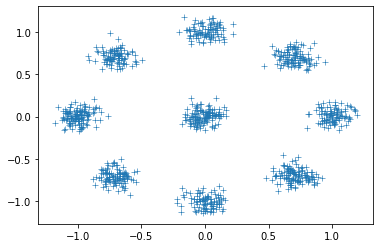

In [21]:
plt.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], marker="+", lw=0.6)

In [22]:
for (x_idx, x), (y_idx, y) in gauss_loader:
    print(x_idx.shape, x.shape, y_idx.shape, y.shape)
    break

torch.Size([300]) torch.Size([300, 2]) torch.Size([300]) torch.Size([300, 2])


We parametrized the $v$ function as neural network as it provided better performance in our setting. Nevertheless, one can use `Vector` to parametrize $v$. In this case don't forget to uncomment corresponding lines.

In [23]:
source_dual_net = nn.Sequential(nn.Linear(2, 200),
                                nn.SELU(),
                                nn.BatchNorm1d(200),
                                nn.Linear(200, 500),
                                nn.SELU(),
                                nn.BatchNorm1d(500),
                                nn.Linear(500, 1)
                                )
target_dual_net = Vector(initial=1e-2 * torch.randn(len(circle_dset)))
# target_dual_net = nn.Sequential(nn.Linear(2, 200),
#                                 nn.BatchNorm1d(200),
#                                 nn.SELU(),
#                                 nn.Linear(200, 500),
#                                 nn.BatchNorm1d(500),
#                                 nn.SELU(),
#                                 nn.Linear(500, 500),
#                                 nn.BatchNorm1d(500),
#                                 nn.SELU(),
#                                 nn.Linear(500, 1)
#                                 )

source_to_target_net = nn.Sequential(nn.Linear(2, 200),
                                nn.SELU(),
                                nn.BatchNorm1d(200),
                                nn.Linear(200, 500),
                                nn.SELU(),
                                nn.BatchNorm1d(500),
                                nn.Linear(500, 2)
                                )

In [24]:
# ot = torch.load('toy_model.pth')
# ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
#               regularization_mode='l2', regularization_parameter=0.05, 
#               from_discrete=False, to_discrete=False).to(DEVICE)

## In the case we use vector, we are working in the discrete setting
ot = NeuralOT(source_dual_net, target_dual_net, source_to_target_net, 
              regularization_mode='l2', regularization_parameter=5e-3, 
              from_discrete=False, to_discrete=True).to(DEVICE)

In [25]:
plan_optimizer = Adam(ot.parameters(), lr=1e-3)
plan_scheduler = None #MultiStepLR(plan_optimizer, [5, 15])

In [26]:
losses = train(ot.plan_criterion, plan_optimizer, gauss_loader, n_epochs=30, device=DEVICE, 
               scheduler=plan_scheduler)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.26it/s]


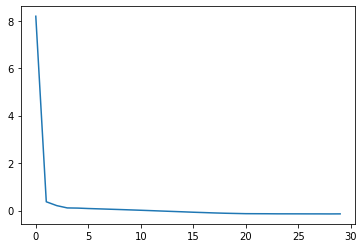

In [27]:
plt.plot(losses)

In [28]:
mapping_optimizer = Adam(ot.parameters(), lr=1e-4)
mapping_scheduler = None

In [29]:
mapping_losses = train(ot.mapping_criterion, mapping_optimizer, gauss_loader, n_epochs=100, device=DEVICE, 
                       scheduler=mapping_scheduler)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.82it/s]


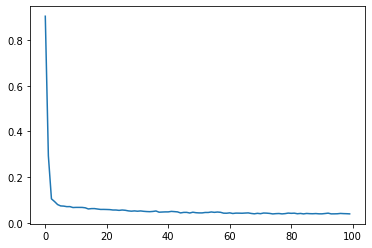

In [30]:
plt.plot(mapping_losses)

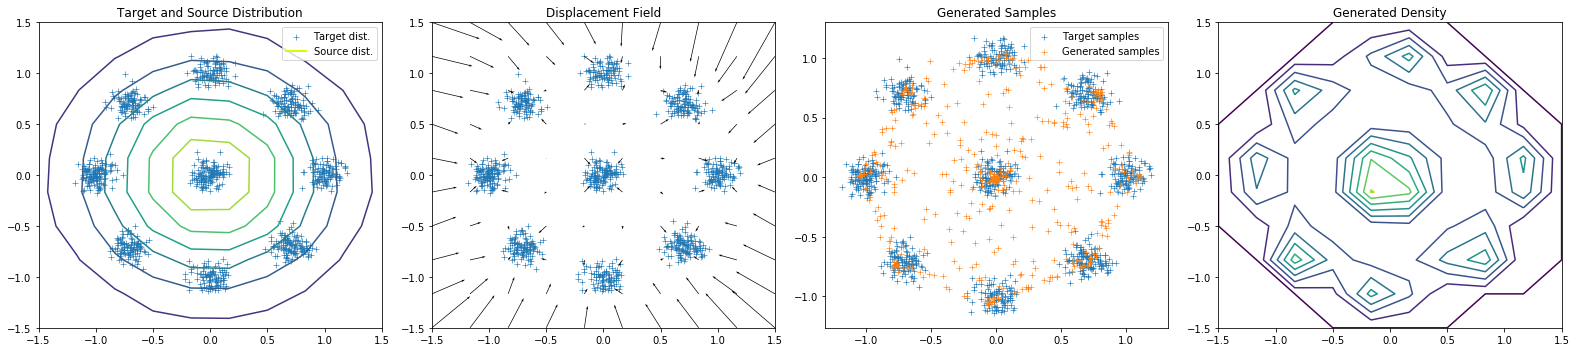

In [31]:
from matplotlib.lines import Line2D
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

n_points = 100000
n_show = 500
xmin, xmax = -1.5, 1.5
ymin, ymax = -1.5, 1.5

idx = np.random.choice(np.arange(n_points, dtype=np.int), n_show,
                       replace=False)

ax = axes[0]
ps = distr.sample([n_points])
with torch.no_grad():
    ps_mapped = ot.cpu().map(ps).detach().numpy()
ps = ps.numpy()
H, xedges, yedges = np.histogram2d(ps[:, 0], ps[:, 1], 
                                   range=[[xmin, xmax], [ymin, ymax]])

ax.contour(H.transpose(), extent=[xedges.min(), xedges.max(), 
                          yedges.min(), yedges.max()])
sc = ax.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], 
           marker="+", lw=0.6, label="Target dist.")
ax.set_title("Target and Source Distribution")
custom_lines = [sc, Line2D([0], [0], color=plt.cm.hsv(0.2), lw=2.)]
ax.legend(custom_lines, ["Target dist.", "Source dist."])

xs = np.linspace(xmin, xmax, num=10)
ys = np.linspace(ymin, ymax, num=10)

ax = axes[1]
XX, YY = np.meshgrid(xs, ys)
XX = torch.tensor(XX.ravel(), dtype=torch.float)
YY = torch.tensor(YY.ravel(), dtype=torch.float)

X = torch.stack([XX, YY], dim=1)
with torch.no_grad():
    Z = ot.cpu().map(X).detach()
offsets = Z - X 

ax.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], 
           marker="+", lw=0.6)
ax.quiver(XX, YY, offsets[:, 0], offsets[:, 1], angles="xy", units="width",
          width=0.002)
ax.set_title("Displacement Field")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax = axes[2]
ax.set_title("Generated Samples")
ax.scatter(circle_dset.data[:, 0], circle_dset.data[:, 1], 
           marker="+", lw=0.6, label="Target samples")
ax.scatter(ps_mapped[idx, 0], ps_mapped[idx, 1], 
           marker="+", lw=0.6, label="Generated samples")
ax.legend()

ax = axes[3]
ax.set_title("Generated Density")
H, xedges, yedges = np.histogram2d(ps_mapped[:, 0], ps_mapped[:, 1], 
                                   range=[[xmin, xmax], [ymin, ymax]])

ax.contour(H.transpose(), extent=[xedges.min(), xedges.max(), 
                          yedges.min(), yedges.max()])
plt.tight_layout()
fig.savefig("gauss.pdf")
plt.show()

In [32]:
torch.save(ot, 'toy_model.pth')